In [133]:
import sqlalchemy
import pandas as pd
import numpy as np

import mplfinance as mpf
import utils.ta_lib_indicators as ti

import ipywidgets as widgets
import talib


In [134]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['Indicators', 'MARA_1_Day_Candles', 'MARA_1_Min_Candles', 'MARA_Info', 'RIOT_1_Day_Candles', 'RIOT_1_Min_Candles', 'RIOT_Info', 'TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info', 'WHD_1_Day_Candles', 'WHD_1_Min_Candles', 'WHD_Info']


In [135]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
stock_ticker = 'RIOT'
daily_df = pd.read_sql_table(
    stock_ticker + '_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table(
    stock_ticker + '_1_Min_Candles', 
    con=engine, 
    index_col='Datetime'
    )

In [136]:
# print(daily_df.tail())

In [137]:
# print(minutely_df.tail())

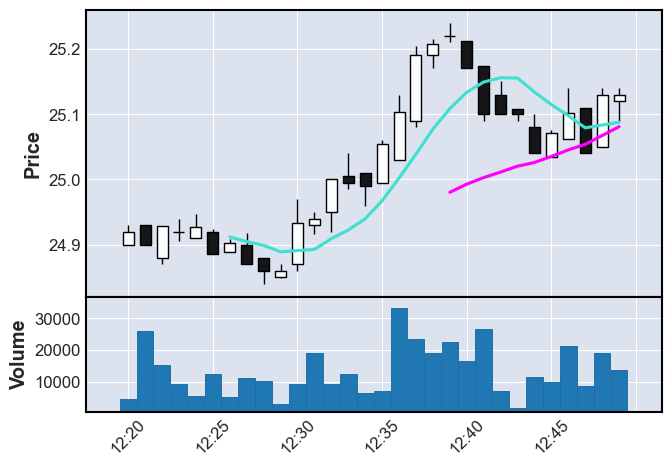

In [138]:
minutely_slice = minutely_df.iloc[-30:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [139]:
pattern_list = []
pattern_df = pd.DataFrame(list(ti.pattern_recognition.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in ti.pattern_recognition.items():
    pattern_list.append(pattern)

In [140]:
df = minutely_df.copy()




In [141]:
sel = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        value=['Doji'],
        rows=min(25, len(pattern_list)),
        description='Candle Pattern:'
    )


In [142]:
output = widgets.Output()

In [143]:
button_submit = widgets.Button(
    description='Submit',
    disabled=False,
    )

In [144]:
display(sel, button_submit, output)
with output:
    print(list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index))

SelectMultiple(description='Candle Pattern:', index=(15,), options=('Two Crows', 'Three Black Crows', 'Three I…

Button(description='Submit', style=ButtonStyle())

Output()

In [157]:

def show_df(b):
    df = minutely_df.copy()
    output.clear_output()
    sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
    for pattern in sel_pattern_list:
        pattern_function = getattr(talib, pattern)
        try:
            result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
            df[pattern] = result
        except Exception as e:
            print(f"{type(e)} Exception! {e}")
    # print(df.head())
    # return df
    with output:
        print(f"{sel_pattern_list}")
        print(df.head())
    # return sel_pattern_list


button_submit.on_click(show_df)



In [158]:
# df = minutely_df.copy()
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())


                      Open   High    Low  Close  Volume  CDLDOJI  \
Datetime                                                           
2021-09-07 03:00:00  37.00  37.00  35.40  35.96    1544        0   
2021-09-07 03:01:00  36.03  36.03  36.03  36.03     560        0   
2021-09-07 03:02:00  36.03  36.04  35.90  35.91    4170        0   
2021-09-07 03:03:00  35.83  35.83  35.83  35.83    4299        0   
2021-09-07 03:04:00  35.75  35.75  35.70  35.70     566        0   

                     Trailing Stop  Trade Signal  Pct Change  Stop Loss  \
Datetime                                                                  
2021-09-07 03:00:00            NaN           0.0         NaN        0.0   
2021-09-07 03:01:00            NaN           0.0    0.001947        0.0   
2021-09-07 03:02:00            NaN           0.0   -0.003331        0.0   
2021-09-07 03:03:00            NaN           0.0   -0.002228        0.0   
2021-09-07 03:04:00            NaN           0.0   -0.003628        0.0  

In [159]:
len(sel_pattern_list)
df['Sum Patterns'] = df.iloc[:, -(len(sel_pattern_list)):].sum(axis=1)
# df.drop(columns=sel_pattern_list, inplace=True)


In [160]:
atr_function = getattr(talib, 'ATR')

atr_result = atr_function(df['High'], df['Low'], df['Close'], timeperiod=14)

atr_factor = 2.5

df['Trailing Stop'] = df['Close'] - (atr_result * atr_factor)



In [161]:
df['Trade Signal'] = 0.0

threshold_value = 0.0

def check_sum_value(sum_value):
    if sum_value > threshold_value:
        return 1
    elif sum_value < -threshold_value:
        return -1
    else:
        return 0.0

df['Trade Signal'] = df['Sum Patterns'].apply(lambda x: check_sum_value(x))
df.drop(columns='Sum Patterns', inplace=True)
       

In [162]:
df['Pct Change'] = df['Close'].pct_change()


In [163]:
df['Stop Loss'] = np.where(df['Trade Signal']==1,df['Trailing Stop'],0.0)

In [164]:
print(df.iloc[:, -4:].tail(20))
print(df['Trade Signal'].value_counts())

                     Trade Signal  Pct Change  Stop Loss  CDL2CROWS
Datetime                                                           
2021-10-04 12:30:00           0.0    0.002965        0.0          0
2021-10-04 12:31:00           0.0    0.000253        0.0          0
2021-10-04 12:32:00           0.0    0.002406        0.0          0
2021-10-04 12:33:00           0.0   -0.000200        0.0          0
2021-10-04 12:34:00           0.0   -0.000200        0.0          0
2021-10-04 12:35:00           0.0    0.002557        0.0          0
2021-10-04 12:36:00           0.0    0.001976        0.0          0
2021-10-04 12:37:00           0.0    0.003450        0.0          0
2021-10-04 12:38:00           0.0    0.000667        0.0          0
2021-10-04 12:39:00           0.0    0.000524        0.0          0
2021-10-04 12:40:00           0.0   -0.001983        0.0          0
2021-10-04 12:41:00           0.0   -0.002781        0.0          0
2021-10-04 12:42:00           0.0    0.000000   

In [165]:
# df['Recalculated Stop Loss'] = pd.NA

# for index, row in df.iterrows():
    
#     if row['Initialize Stop Loss'] > 0.0:
#         df.loc[index, 'Recalculated Stop Loss'] = row['Initialize Stop Loss']

#     elif row['Initialize Stop Loss'] > 0.0 or row['Pct Change'] > 0.0:
#         if row['Trailing Stop'] > row['Recalculated Stop Loss'].shift(1):
#             df.loc[index,'Recalculated Stop Loss'] = row['Trailing Stop']
#         else:
#             df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)
    
#     else:
#         df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)

In [166]:
last_stop = 0.0
# df['Recalculated Stop Loss'] = pd.NA
for index, row in df.iterrows():
    if row['Pct Change'] > 0.0 and row['Trailing Stop'] > last_stop:
        df.loc[index,'Stop Loss'] = row['Trailing Stop']
    else:
        df.loc[index,'Stop Loss'] = last_stop

    last_stop = row['Stop Loss']


In [167]:
print(df.iloc[:, -5:].head(20))

                     Trailing Stop  Trade Signal  Pct Change  Stop Loss  \
Datetime                                                                  
2021-09-07 03:00:00            NaN           0.0         NaN   0.000000   
2021-09-07 03:01:00            NaN           0.0    0.001947   0.000000   
2021-09-07 03:02:00            NaN           0.0   -0.003331   0.000000   
2021-09-07 03:03:00            NaN           0.0   -0.002228   0.000000   
2021-09-07 03:04:00            NaN           0.0   -0.003628   0.000000   
2021-09-07 03:05:00            NaN           0.0    0.000000   0.000000   
2021-09-07 03:06:00            NaN           0.0    0.000280   0.000000   
2021-09-07 03:07:00            NaN           0.0   -0.000280   0.000000   
2021-09-07 03:08:00            NaN           0.0   -0.003922   0.000000   
2021-09-07 03:10:00            NaN           0.0    0.003937   0.000000   
2021-09-07 03:12:00            NaN           0.0   -0.005042   0.000000   
2021-09-07 03:18:00      

In [168]:
df.dropna().to_sql('Indicators', con=engine, if_exists='replace')